# 10-Year Baseline PCA Analysis (2015-2025)

## Objective
Build a comprehensive 10-year baseline PCA model for **ALL 7 categories** to enable absolute scoring across time.

**Key Questions:**
1. What is PC1 variance for each category across 10 years?
2. Which metrics consistently dominate PC1 loadings?
3. Are loadings stable across individual years?
4. Can we use this baseline for absolute scoring in 2025-2026?

**Data:**
- 10 seasons (2015-2025): ~200 squad-seasons
- 7 categories: attacking_output, creativity, passing, ball_progression, defending, physical_duels, possession
- 169 total metrics

---

In [70]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pca_analysis_utils import *

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports complete")

✅ Imports complete


In [71]:
# Connect to analytics database
db_path = '../data/premierleague_analytics.duckdb'
conn = duckdb.connect(db_path, read_only=True)

print(f"✅ Connected to: {db_path}")

✅ Connected to: ../data/premierleague_analytics.duckdb


## 1. Load 10 Years of Squad Data (2015-2025)

In [72]:
# Load all squad stats from 2015-2025 (10 seasons)
query = """
SELECT *
FROM analytics_squads
WHERE season >= '2015-2016' AND season < '2024-2025'
ORDER BY season, squad_name
"""

df_10yr = conn.execute(query).df()

print(f"📊 Loaded 9-year baseline data:")
print(f"   Seasons: {df_10yr['season'].nunique()}")
print(f"   Squad-seasons: {len(df_10yr)}")
print(f"   Columns: {len(df_10yr.columns)}")
print(f"\nSeasons included:")
print(df_10yr['season'].value_counts().sort_index())

📊 Loaded 9-year baseline data:
   Seasons: 9
   Squad-seasons: 180
   Columns: 184

Seasons included:
season
2015-2016    20
2016-2017    20
2017-2018    20
2018-2019    20
2019-2020    20
2020-2021    20
2021-2022    20
2022-2023    20
2023-2024    20
Name: count, dtype: int64


In [73]:
# Define negative metrics (where lower is better)
NEGATIVE_METRICS = {'penalty_kicks_attempted_against', 'miscontrols', 'goals_against_per_90', 'yellow_cards', 'challenges_lost', 'own_goals_for', 'penalty_goals_against', 'aerial_duels_lost', 'goals_against', 'take_ons_tackled_rate', 'fouls_committed', 'offsides_pass_types', 'blocked_passes', 'corner_kick_goals_against', 'dispossessed', 'crosses_faced', 'penalty_kicks_against', 'free_kick_goals_against', 'second_yellow_cards', 'take_ons_tackled', 'errors', 'offsides', 'red_cards', 'average_shot_distance', 'shots_on_target_against', 'own_goals', 'penalty_kicks_conceded'}

print(f"📌 Negative metrics to invert: {len(NEGATIVE_METRICS)}")

📌 Negative metrics to invert: 27


## 2. Extract ALL 7 Categories

In [74]:
# Load category definitions
with open('full_categories.json', 'r') as f:
    FULL_CATEGORIES = json.load(f)

# Prepare data for all categories
category_data = {}
category_metrics = {}

print("="*80)
print("CATEGORY DATA EXTRACTION")
print("="*80)

for cat_name in FULL_CATEGORIES.keys():
    cat_df, metrics, inv_count = prepare_category_data(df_10yr, cat_name, NEGATIVE_METRICS)
    category_data[cat_name] = cat_df
    category_metrics[cat_name] = metrics

    print(f"\n🎯 {cat_name}")
    print(f"   Total metrics: {len(metrics)}")
    print(f"   Inverted (negative): {inv_count}")
    print(f"   Rows: {len(cat_df)}")

print("\n" + "="*80)
print(f"✅ ALL {len(FULL_CATEGORIES)} categories extracted")
print("="*80)

CATEGORY DATA EXTRACTION

🎯 attacking_output
   Total metrics: 33
   Inverted (negative): 2
   Rows: 180

🎯 creativity
   Total metrics: 25
   Inverted (negative): 0
   Rows: 180

🎯 passing
   Total metrics: 28
   Inverted (negative): 2
   Rows: 180

🎯 ball_progression
   Total metrics: 18
   Inverted (negative): 4
   Rows: 180

🎯 defending
   Total metrics: 38
   Inverted (negative): 13
   Rows: 180

🎯 physical_duels
   Total metrics: 15
   Inverted (negative): 6
   Rows: 180

🎯 possession
   Total metrics: 12
   Inverted (negative): 0
   Rows: 180

✅ ALL 7 categories extracted


/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cat_df[metric].fillna(0, inplace=True)
/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

## 3. Fit 10-Year Baseline PCA for ALL Categories

In [75]:
baseline_results = {}

print("="*80)
print("10-YEAR BASELINE PCA FITTING")
print("="*80)

for cat_name in FULL_CATEGORIES.keys():
    cat_df = category_data[cat_name]
    metrics = category_metrics[cat_name]

    # Get feature matrix
    X = cat_df[metrics].values

    # Fit PCA
    results = fit_pca_model(X, variance_threshold=0.80)

    # Get top loadings
    top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)
    results['top_metric'] = top_loadings.index[0]
    results['top_loading'] = top_loadings.iloc[0]
    results['top_loadings'] = top_loadings

    baseline_results[cat_name] = results

    # Print results
    print_category_results(cat_name, results, metrics)

print("\n" + "="*80)
print(f"✅ PCA fitted for ALL {len(FULL_CATEGORIES)} categories")
print("="*80)

10-YEAR BASELINE PCA FITTING

🎯 attacking_output
   ──────────────────────────────────────────────────────────────────────
   PC1 Variance: 55.3%
   Components:   3 (explaining 85.3%)
   Metrics:      33

   Top 5 PC1 Contributors:
      1. expected_assisted_goals                  0.1982
      2. expected_assisted_goals_per_90           0.1982
      3. xg_plus_xag_per_90                       0.1979
      4. non_penalty_xg_plus_xag                  0.1972
      5. non_penalty_xg_plus_xag_per_90           0.1972

🎯 creativity
   ──────────────────────────────────────────────────────────────────────
   PC1 Variance: 73.3%
   Components:   2 (explaining 80.4%)
   Metrics:      25

   Top 5 PC1 Contributors:
      1. shot_creating_actions                    0.2317
      2. shot_creating_actions_per_90             0.2317
      3. key_passes                               0.2311
      4. sca_pass_live                            0.2302
      5. corner_kicks                             0.2290



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_

## 4. Summary Table - All Categories

In [76]:
summary_df = create_summary_table(baseline_results)
display(summary_df)

print("\n📊 Key Findings:")
high_pc1 = summary_df[summary_df['PC1 Variance'].str.rstrip('%').astype(float) > 50]
print(f"   - Categories with PC1 > 50%: {len(high_pc1)}")
print(f"     {', '.join(high_pc1['Category'].tolist())}")

,Category,PC1 Variance,Components Used,Total Variance,Top Loading
0,attacking_output,55.3%,3,85.3%,expected_assisted_goals (0.1982)
1,creativity,73.3%,2,80.4%,shot_creating_actions (0.2317)
2,passing,87.5%,1,87.5%,progressive_pass_distance (0.2010)
3,ball_progression,84.9%,1,84.9%,carry_distance (0.2508)
4,defending,46.1%,5,82.9%,blocks (0.2313)
5,physical_duels,55.6%,4,83.2%,aerial_duel_success_rate (0.3338)
6,possession,77.6%,2,90.8%,touches_def_third (0.3150)



📊 Key Findings:
   - Categories with PC1 > 50%: 6
     attacking_output, creativity, passing, ball_progression, physical_duels, possession


## 5. PC1 Variance Comparison Across Categories

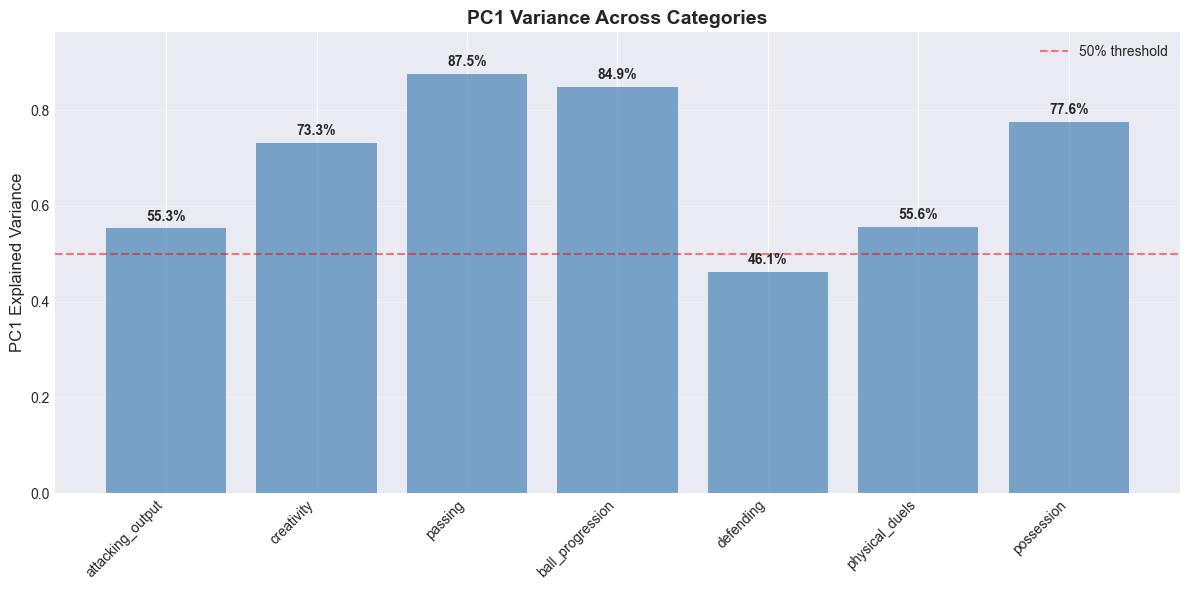


💡 Interpretation:
   - Higher PC1 variance = metrics are more correlated
   - Lower PC1 variance = metrics measure different aspects
   - PC1 > 50% suggests strong underlying dimension


In [77]:
fig = plot_pc1_variance_comparison(baseline_results)
plt.show()

print("\n💡 Interpretation:")
print("   - Higher PC1 variance = metrics are more correlated")
print("   - Lower PC1 variance = metrics measure different aspects")
print("   - PC1 > 50% suggests strong underlying dimension")

## 6. Loading Stability Test

**Question:** Are the top PC1 loadings consistent across individual years?

**Method:**
- Fit PCA on each year individually (2015-2024)
- Compare top 5 loadings across years
- Metrics appearing in top 5 for 80%+ of years = stable

### 6.1 Stability: attacking_output

In [78]:
# Fit PCA on each year individually for attacking_output
cat_name = 'attacking_output'
yearly_results = {}
years = range(2015, 2024)  # 2015-2024 (10 years)

for year in years:
    # Filter to single season
    season = f"{year}-{year+1}"
    df_year = df_10yr[df_10yr['season'] == season]

    if len(df_year) < 5:  # Skip if too few samples
        continue

    # Prepare data
    cat_df, metrics, _ = prepare_category_data(df_year, cat_name, NEGATIVE_METRICS)
    X = cat_df[metrics].values

    # Fit PCA
    results = fit_pca_model(X)
    top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)

    yearly_results[season] = {
        'pc1_variance': results['pc1_variance'],
        'top_loadings': top_loadings.index.tolist()  # <-- Use index (metric names)
    }

# Analyze stability
all_top_loadings = {s: r['top_loadings'] for s, r in yearly_results.items()}
stability = analyze_stability(all_top_loadings, list(yearly_results.keys()), n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"Years analyzed: {len(yearly_results)}")
print(f"\nTop 5 metric frequencies across years:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(yearly_results) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:<45} {count}/{len(yearly_results)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of years):")
print(f"   {', '.join(stability['stable_metrics'])}")
print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall assessment: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability results
baseline_results[cat_name]['stability'] = stability
baseline_results[cat_name]['yearly_results'] = yearly_results

attacking_output - Stability Analysis
Years analyzed: 9

Top 5 metric frequencies across years:
  goals_plus_assists                            9/9 ████████████████████ 100%
  goals_plus_assists_per_90                     8/9 █████████████████ 89%
  goals_per_90                                  8/9 █████████████████ 89%
  goals                                         8/9 █████████████████ 89%
  non_penalty_goals_per_90                      5/9 ███████████ 56%
  goals_plus_assists_minus_pks_per_90           4/9 ████████ 44%
  non_penalty_goals                             3/9 ██████ 33%

✅ Stable metrics (appear in 80%+ of years):
   goals_plus_assists, goals_plus_assists_per_90, goals_per_90, goals

Stability score: 80.0%
Overall assessment: ✅ STABLE


/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cat_df[metric].fillna(0, inplace=True)
/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

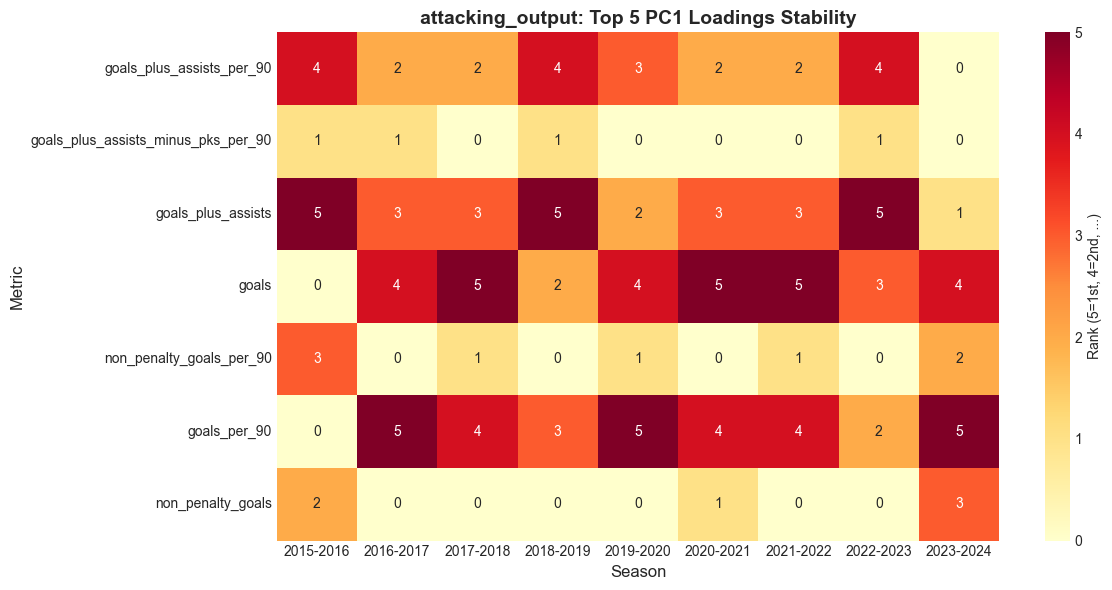


📊 Heatmap interpretation:
   - Bright cells (5) = metric is #1 contributor that year
   - Dark cells (0) = metric not in top 5 that year
   - Consistent rows = stable metrics across time


In [79]:
# Heatmap: Which metrics appear in top 5 across years?
fig = plot_loading_stability_heatmap('attacking_output', all_top_loadings, list(yearly_results.keys()))
plt.show()

print("\n📊 Heatmap interpretation:")
print("   - Bright cells (5) = metric is #1 contributor that year")
print("   - Dark cells (0) = metric not in top 5 that year")
print("   - Consistent rows = stable metrics across time")

### 6.2 Stability: creativity

In [80]:
# Fit PCA on each year individually for creativity
cat_name = 'creativity'
yearly_results = {}
years = range(2015, 2024)  # 2015-2024 (10 years)

for year in years:
    # Filter to single season
    season = f"{year}-{year+1}"
    df_year = df_10yr[df_10yr['season'] == season]

    if len(df_year) < 5:  # Skip if too few samples
        continue

    # Prepare data
    cat_df, metrics, _ = prepare_category_data(df_year, cat_name, NEGATIVE_METRICS)
    X = cat_df[metrics].values

    # Fit PCA
    results = fit_pca_model(X)
    top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)

    yearly_results[season] = {
        'pc1_variance': results['pc1_variance'],
        'top_loadings': top_loadings.index.tolist()
    }

# Analyze stability
all_top_loadings = {s: r['top_loadings'] for s, r in yearly_results.items()}
stability = analyze_stability(all_top_loadings, list(yearly_results.keys()), n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"Years analyzed: {len(yearly_results)}")
print(f"\nTop 5 metric frequencies across years:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(yearly_results) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(yearly_results)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of years):")
print(f"   {', '.join(stability['stable_metrics'])}")
print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall assessment: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability results
baseline_results[cat_name]['stability'] = stability
baseline_results[cat_name]['yearly_results'] = yearly_results

creativity - Stability Analysis
Years analyzed: 9

Top 5 metric frequencies across years:
  key_passes                                    9/9 ████████████████████ 100%
  shot_creating_actions                         9/9 ████████████████████ 100%
  shot_creating_actions_per_90                  8/9 █████████████████ 89%
  sca_pass_live                                 6/9 █████████████ 67%
  goal_creating_actions                         3/9 ██████ 33%
  passes_penalty_area                           3/9 ██████ 33%
  assists_passing                               2/9 ████ 22%
  crosses                                       1/9 ██ 11%
  gca_pass_live                                 1/9 ██ 11%
  goal_creating_actions_per_90                  1/9 ██ 11%

✅ Stable metrics (appear in 80%+ of years):
   key_passes, shot_creating_actions, shot_creating_actions_per_90

Stability score: 60.0%
Overall assessment: ✅ STABLE


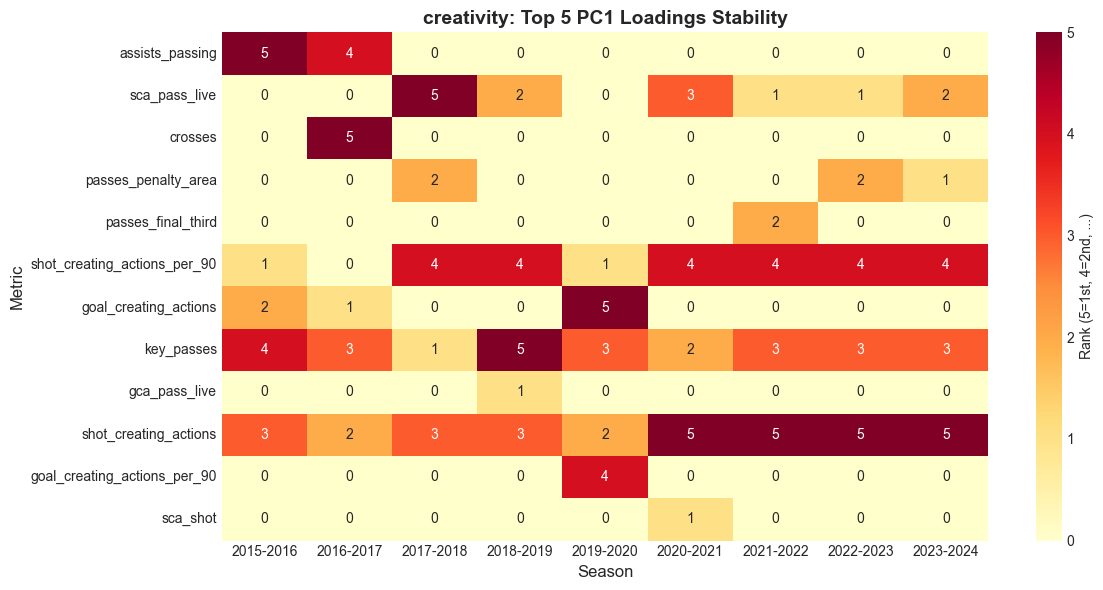


📊 Heatmap interpretation:
   - Bright cells (5) = metric is #1 contributor that year
   - Dark cells (0) = metric not in top 5 that year
   - Consistent rows = stable metrics across time


In [81]:
# Heatmap: Which metrics appear in top 5 across years?
fig = plot_loading_stability_heatmap('creativity', all_top_loadings, list(yearly_results.keys()))
plt.show()

print("\n📊 Heatmap interpretation:")
print("   - Bright cells (5) = metric is #1 contributor that year")
print("   - Dark cells (0) = metric not in top 5 that year")
print("   - Consistent rows = stable metrics across time")

### 6.3 Stability: passing

In [82]:
# Fit PCA on each year individually for passing
cat_name = 'passing'
yearly_results = {}
years = range(2015, 2024)  # 2015-2024 (10 years)

for year in years:
    # Filter to single season
    season = f"{year}-{year+1}"
    df_year = df_10yr[df_10yr['season'] == season]

    if len(df_year) < 5:  # Skip if too few samples
        continue

    # Prepare data
    cat_df, metrics, _ = prepare_category_data(df_year, cat_name, NEGATIVE_METRICS)
    X = cat_df[metrics].values

    # Fit PCA
    results = fit_pca_model(X)
    top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)

    yearly_results[season] = {
        'pc1_variance': results['pc1_variance'],
        'top_loadings': top_loadings.index.tolist()
    }

# Analyze stability
all_top_loadings = {s: r['top_loadings'] for s, r in yearly_results.items()}
stability = analyze_stability(all_top_loadings, list(yearly_results.keys()), n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"Years analyzed: {len(yearly_results)}")
print(f"\nTop 5 metric frequencies across years:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(yearly_results) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(yearly_results)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of years):")
print(f"   {', '.join(stability['stable_metrics'])}")
print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall assessment: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability results
baseline_results[cat_name]['stability'] = stability
baseline_results[cat_name]['yearly_results'] = yearly_results

passing - Stability Analysis
Years analyzed: 9

Top 5 metric frequencies across years:
  passes_completed                              9/9 ████████████████████ 100%
  total_pass_distance                           8/9 █████████████████ 89%
  passes_attempted                              7/9 ███████████████ 78%
  completed_passes_types                        7/9 ███████████████ 78%
  live_ball_passes                              6/9 █████████████ 67%
  pass_completion_rate                          3/9 ██████ 33%
  progressive_pass_distance                     2/9 ████ 22%
  medium_passes_completed                       2/9 ████ 22%
  medium_passes_attempted                       1/9 ██ 11%

✅ Stable metrics (appear in 80%+ of years):
   passes_completed, total_pass_distance

Stability score: 40.0%
Overall assessment: ⚠️  UNSTABLE


/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cat_df[metric].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarn

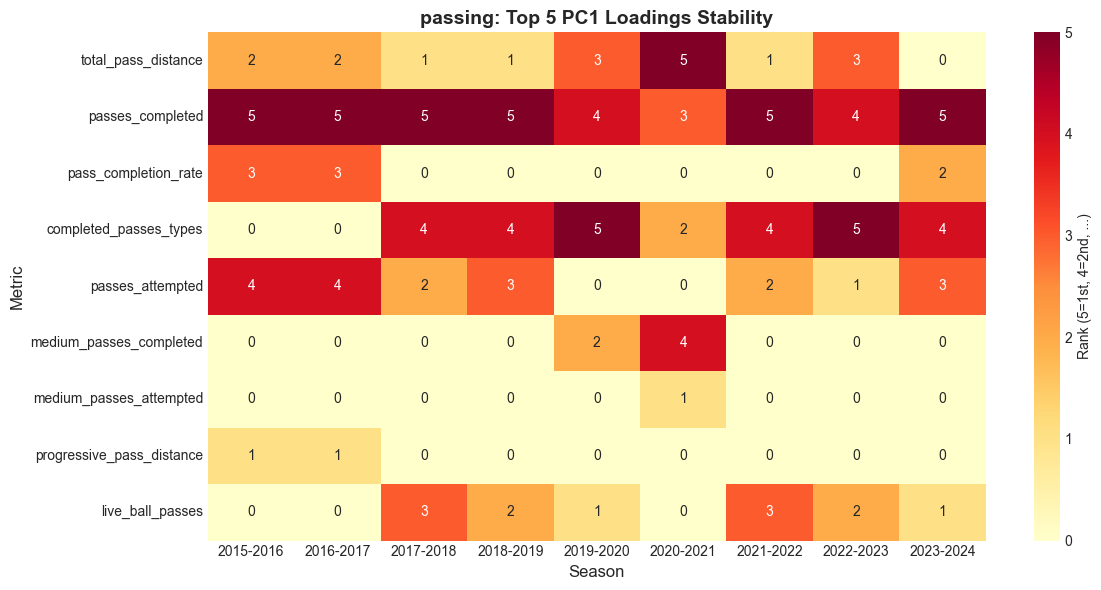


📊 Heatmap interpretation:
   - Bright cells (5) = metric is #1 contributor that year
   - Dark cells (0) = metric not in top 5 that year
   - Consistent rows = stable metrics across time


In [83]:
# Heatmap: Which metrics appear in top 5 across years?
fig = plot_loading_stability_heatmap('passing', all_top_loadings, list(yearly_results.keys()))
plt.show()

print("\n📊 Heatmap interpretation:")
print("   - Bright cells (5) = metric is #1 contributor that year")
print("   - Dark cells (0) = metric not in top 5 that year")
print("   - Consistent rows = stable metrics across time")

### 6.4 Stability: ball_progression

In [84]:
# Fit PCA on each year individually for ball_progression
cat_name = 'ball_progression'
yearly_results = {}
years = range(2015, 2024)  # 2015-2024 (10 years)

for year in years:
    # Filter to single season
    season = f"{year}-{year+1}"
    df_year = df_10yr[df_10yr['season'] == season]

    if len(df_year) < 5:  # Skip if too few samples
        continue

    # Prepare data
    cat_df, metrics, _ = prepare_category_data(df_year, cat_name, NEGATIVE_METRICS)
    X = cat_df[metrics].values

    # Fit PCA
    results = fit_pca_model(X)
    top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)

    yearly_results[season] = {
        'pc1_variance': results['pc1_variance'],
        'top_loadings': top_loadings.index.tolist()
    }

# Analyze stability
all_top_loadings = {s: r['top_loadings'] for s, r in yearly_results.items()}
stability = analyze_stability(all_top_loadings, list(yearly_results.keys()), n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"Years analyzed: {len(yearly_results)}")
print(f"\nTop 5 metric frequencies across years:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(yearly_results) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(yearly_results)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of years):")
print(f"   {', '.join(stability['stable_metrics'])}")
print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall assessment: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability results
baseline_results[cat_name]['stability'] = stability
baseline_results[cat_name]['yearly_results'] = yearly_results

ball_progression - Stability Analysis
Years analyzed: 9

Top 5 metric frequencies across years:
  progressive_carries                           9/9 ████████████████████ 100%
  carry_distance                                9/9 ████████████████████ 100%
  progressive_carry_distance                    9/9 ████████████████████ 100%
  carries_final_third                           8/9 █████████████████ 89%
  carries                                       6/9 █████████████ 67%
  carries_penalty_area                          2/9 ████ 22%
  progressive_passes_received_detail            1/9 ██ 11%
  passes_received                               1/9 ██ 11%

✅ Stable metrics (appear in 80%+ of years):
   progressive_carries, carry_distance, progressive_carry_distance, carries_final_third

Stability score: 80.0%
Overall assessment: ✅ STABLE


/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cat_df[metric].fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarn

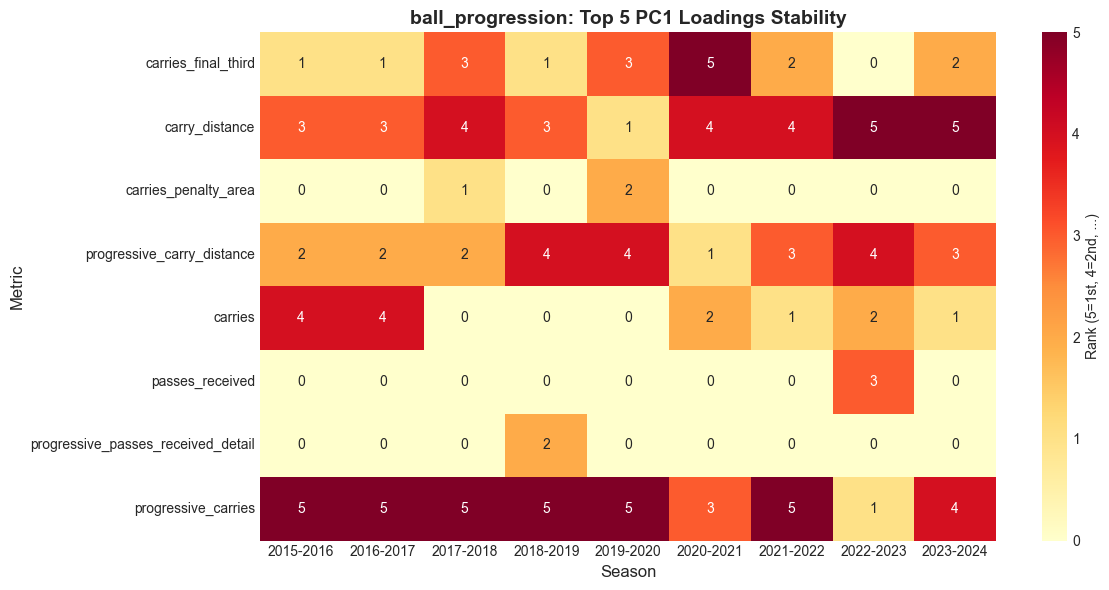


📊 Heatmap interpretation:
   - Bright cells (5) = metric is #1 contributor that year
   - Dark cells (0) = metric not in top 5 that year
   - Consistent rows = stable metrics across time


In [85]:
# Heatmap: Which metrics appear in top 5 across years?
fig = plot_loading_stability_heatmap('ball_progression', all_top_loadings, list(yearly_results.keys()))
plt.show()

print("\n📊 Heatmap interpretation:")
print("   - Bright cells (5) = metric is #1 contributor that year")
print("   - Dark cells (0) = metric not in top 5 that year")
print("   - Consistent rows = stable metrics across time")

### 6.5 Stability: defending

In [86]:
# Fit PCA on each year individually for defending
cat_name = 'defending'
yearly_results = {}
years = range(2015, 2024)  # 2015-2024 (10 years)

for year in years:
    # Filter to single season
    season = f"{year}-{year+1}"
    df_year = df_10yr[df_10yr['season'] == season]

    if len(df_year) < 5:  # Skip if too few samples
        continue

    # Prepare data
    cat_df, metrics, _ = prepare_category_data(df_year, cat_name, NEGATIVE_METRICS)
    X = cat_df[metrics].values

    # Fit PCA
    results = fit_pca_model(X)
    top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)

    yearly_results[season] = {
        'pc1_variance': results['pc1_variance'],
        'top_loadings': top_loadings.index.tolist()
    }

# Analyze stability
all_top_loadings = {s: r['top_loadings'] for s, r in yearly_results.items()}
stability = analyze_stability(all_top_loadings, list(yearly_results.keys()), n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"Years analyzed: {len(yearly_results)}")
print(f"\nTop 5 metric frequencies across years:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(yearly_results) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(yearly_results)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of years):")
print(f"   {', '.join(stability['stable_metrics'])}")
print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall assessment: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability results
baseline_results[cat_name]['stability'] = stability
baseline_results[cat_name]['yearly_results'] = yearly_results

defending - Stability Analysis
Years analyzed: 9

Top 5 metric frequencies across years:
  goals_against_per_90                          9/9 ████████████████████ 100%
  goals_against                                 8/9 █████████████████ 89%
  clean_sheets                                  6/9 █████████████ 67%
  clean_sheet_percentage                        6/9 █████████████ 67%
  shots_on_target_against                       5/9 ███████████ 56%
  post_shot_expected_goals                      3/9 ██████ 33%
  tackles_plus_interceptions                    2/9 ████ 22%
  blocks                                        2/9 ████ 22%
  tackles_def_third                             1/9 ██ 11%
  challenge_tackles                             1/9 ██ 11%

✅ Stable metrics (appear in 80%+ of years):
   goals_against, goals_against_per_90

Stability score: 40.0%
Overall assessment: ⚠️  UNSTABLE


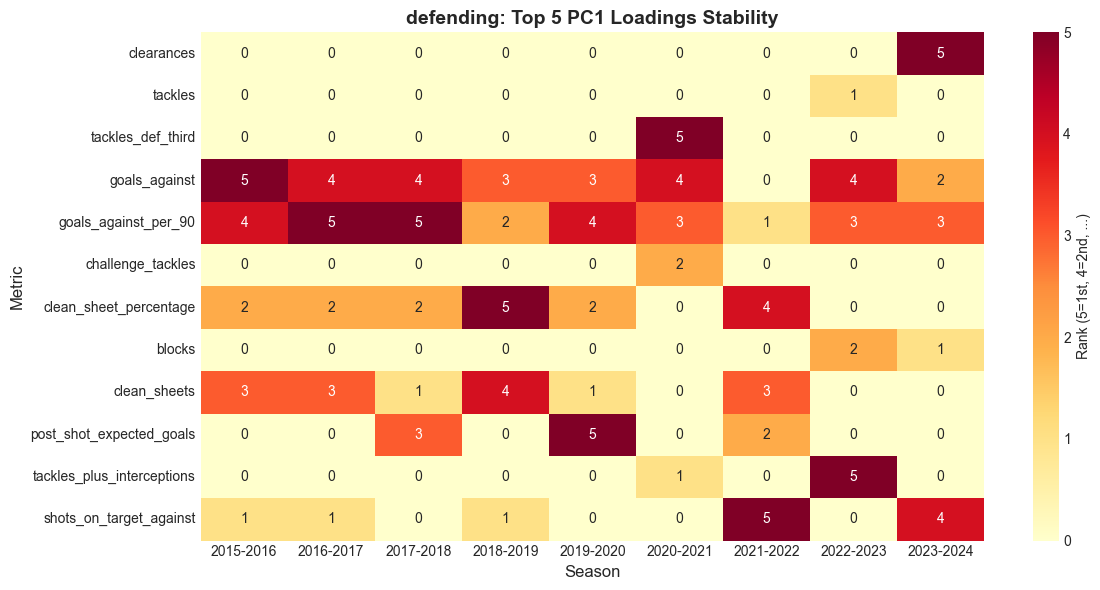


📊 Heatmap interpretation:
   - Bright cells (5) = metric is #1 contributor that year
   - Dark cells (0) = metric not in top 5 that year
   - Consistent rows = stable metrics across time


In [87]:
# Heatmap: Which metrics appear in top 5 across years?
fig = plot_loading_stability_heatmap('defending', all_top_loadings, list(yearly_results.keys()))
plt.show()

print("\n📊 Heatmap interpretation:")
print("   - Bright cells (5) = metric is #1 contributor that year")
print("   - Dark cells (0) = metric not in top 5 that year")
print("   - Consistent rows = stable metrics across time")

### 6.6 Stability: physical_duels

In [88]:
# Fit PCA on each year individually for physical_duels
cat_name = 'physical_duels'
yearly_results = {}
years = range(2015, 2024)  # 2015-2024 (10 years)

for year in years:
    # Filter to single season
    season = f"{year}-{year+1}"
    df_year = df_10yr[df_10yr['season'] == season]

    if len(df_year) < 5:  # Skip if too few samples
        continue

    # Prepare data
    cat_df, metrics, _ = prepare_category_data(df_year, cat_name, NEGATIVE_METRICS)
    X = cat_df[metrics].values

    # Fit PCA
    results = fit_pca_model(X)
    top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)

    yearly_results[season] = {
        'pc1_variance': results['pc1_variance'],
        'top_loadings': top_loadings.index.tolist()
    }

# Analyze stability
all_top_loadings = {s: r['top_loadings'] for s, r in yearly_results.items()}
stability = analyze_stability(all_top_loadings, list(yearly_results.keys()), n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"Years analyzed: {len(yearly_results)}")
print(f"\nTop 5 metric frequencies across years:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(yearly_results) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(yearly_results)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of years):")
print(f"   {', '.join(stability['stable_metrics'])}")
print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall assessment: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability results
baseline_results[cat_name]['stability'] = stability
baseline_results[cat_name]['yearly_results'] = yearly_results

physical_duels - Stability Analysis
Years analyzed: 9

Top 5 metric frequencies across years:
  aerial_duels_lost                             7/9 ███████████████ 78%
  yellow_cards                                  6/9 █████████████ 67%
  crosses_faced                                 6/9 █████████████ 67%
  fouls_committed                               4/9 ████████ 44%
  aerial_duels_won                              4/9 ████████ 44%
  second_yellow_cards                           4/9 ████████ 44%
  defensive_actions_outside_penalty_area_per_90 3/9 ██████ 33%
  aerial_duel_success_rate                      2/9 ████ 22%
  red_cards                                     2/9 ████ 22%
  fouls_drawn                                   2/9 ████ 22%

✅ Stable metrics (appear in 80%+ of years):
   

Stability score: 0.0%
Overall assessment: ⚠️  UNSTABLE


/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cat_df[metric].fillna(0, inplace=True)
/Users/aniketmutatkar/Documents/Python/PremierLeagueStatistics/ml-pca-testing/pca_analysis_utils.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

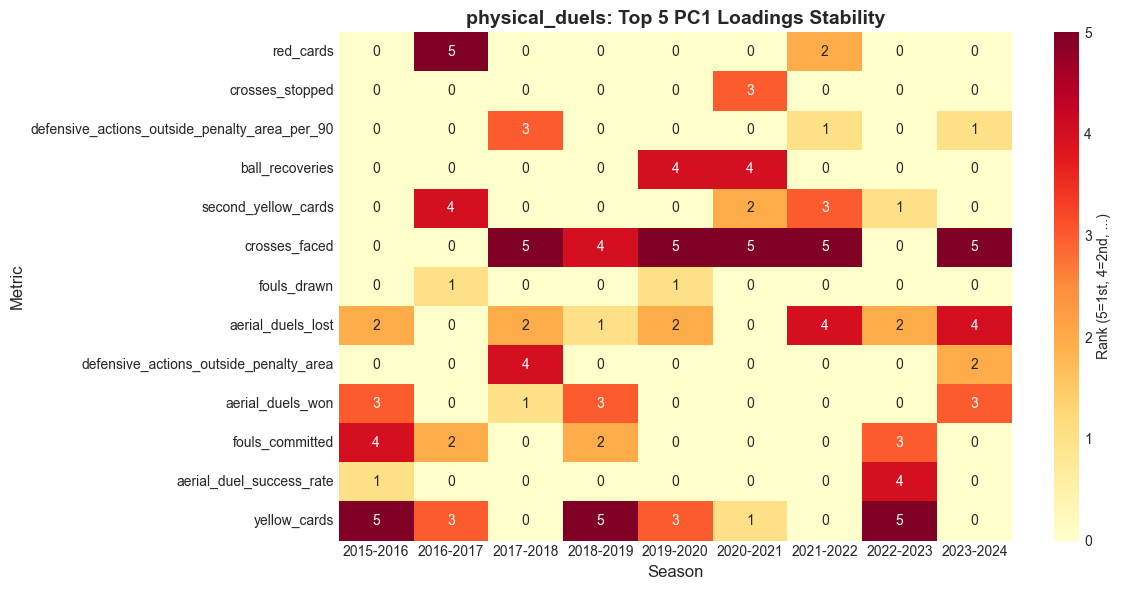


📊 Heatmap interpretation:
   - Bright cells (5) = metric is #1 contributor that year
   - Dark cells (0) = metric not in top 5 that year
   - Consistent rows = stable metrics across time


In [89]:
# Heatmap: Which metrics appear in top 5 across years?
fig = plot_loading_stability_heatmap('physical_duels', all_top_loadings, list(yearly_results.keys()))
plt.show()

print("\n📊 Heatmap interpretation:")
print("   - Bright cells (5) = metric is #1 contributor that year")
print("   - Dark cells (0) = metric not in top 5 that year")
print("   - Consistent rows = stable metrics across time")

### 6.7 Stability: possession

In [90]:
# Fit PCA on each year individually for possession
cat_name = 'possession'
yearly_results = {}
years = range(2015, 2024)  # 2015-2024 (10 years)

for year in years:
    # Filter to single season
    season = f"{year}-{year+1}"
    df_year = df_10yr[df_10yr['season'] == season]

    if len(df_year) < 5:  # Skip if too few samples
        continue

    # Prepare data
    cat_df, metrics, _ = prepare_category_data(df_year, cat_name, NEGATIVE_METRICS)
    X = cat_df[metrics].values

    # Fit PCA
    results = fit_pca_model(X)
    top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)

    yearly_results[season] = {
        'pc1_variance': results['pc1_variance'],
        'top_loadings': top_loadings.index.tolist()
    }

# Analyze stability
all_top_loadings = {s: r['top_loadings'] for s, r in yearly_results.items()}
stability = analyze_stability(all_top_loadings, list(yearly_results.keys()), n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"Years analyzed: {len(yearly_results)}")
print(f"\nTop 5 metric frequencies across years:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(yearly_results) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(yearly_results)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of years):")
print(f"   {', '.join(stability['stable_metrics'])}")
print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall assessment: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability results
baseline_results[cat_name]['stability'] = stability
baseline_results[cat_name]['yearly_results'] = yearly_results

possession - Stability Analysis
Years analyzed: 9

Top 5 metric frequencies across years:
  touches                                       9/9 ████████████████████ 100%
  touches_mid_third                             8/9 █████████████████ 89%
  touches_att_third                             7/9 ███████████████ 78%
  touches_live_ball                             7/9 ███████████████ 78%
  launch_percentage                             3/9 ██████ 33%
  goal_kick_launch_percentage                   3/9 ██████ 33%
  touches_def_penalty                           2/9 ████ 22%
  touches_def_third                             2/9 ████ 22%
  touches_att_penalty                           2/9 ████ 22%
  crosses_misc                                  1/9 ██ 11%

✅ Stable metrics (appear in 80%+ of years):
   touches, touches_mid_third

Stability score: 40.0%
Overall assessment: ⚠️  UNSTABLE


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


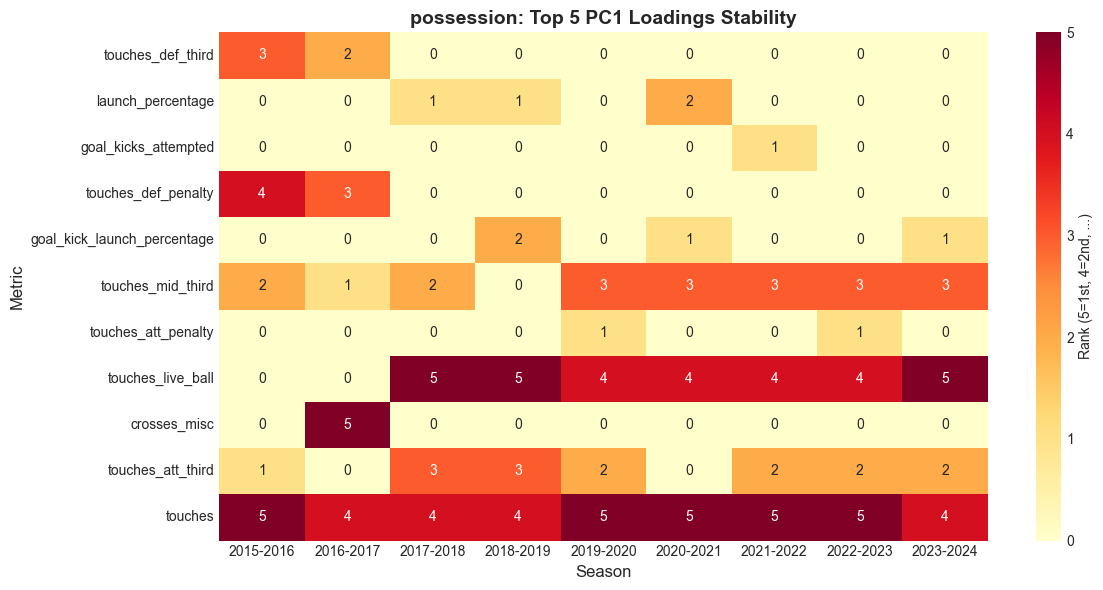


📊 Heatmap interpretation:
   - Bright cells (5) = metric is #1 contributor that year
   - Dark cells (0) = metric not in top 5 that year
   - Consistent rows = stable metrics across time


In [91]:
# Heatmap: Which metrics appear in top 5 across years?
fig = plot_loading_stability_heatmap('possession', all_top_loadings, list(yearly_results.keys()))
plt.show()

print("\n📊 Heatmap interpretation:")
print("   - Bright cells (5) = metric is #1 contributor that year")
print("   - Dark cells (0) = metric not in top 5 that year")
print("   - Consistent rows = stable metrics across time")

## 7. Overall Stability Summary

In [92]:
print("="*80)
print("STABILITY SUMMARY - ALL CATEGORIES")
print("="*80)

stability_summary = []
for cat_name in FULL_CATEGORIES.keys():
    stability = baseline_results[cat_name]['stability']
    pc1_var = baseline_results[cat_name]['pc1_variance']

    stability_summary.append({
        'Category': cat_name,
        'PC1 Variance': f"{pc1_var:.1%}",
        'Stability Score': f"{stability['stability_score']:.1%}",
        'Stable Metrics': len(stability['stable_metrics']),
        'Assessment': '✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'
    })

df_stability = pd.DataFrame(stability_summary)
display(df_stability)

stable_count = df_stability['Assessment'].str.contains('STABLE').sum()
print(f"\n📊 Results: {stable_count}/{len(FULL_CATEGORIES)} categories have stable loadings")

STABILITY SUMMARY - ALL CATEGORIES


,Category,PC1 Variance,Stability Score,Stable Metrics,Assessment
0,attacking_output,55.3%,80.0%,4,✅ STABLE
1,creativity,73.3%,60.0%,3,✅ STABLE
2,passing,87.5%,40.0%,2,⚠️ UNSTABLE
3,ball_progression,84.9%,80.0%,4,✅ STABLE
4,defending,46.1%,40.0%,2,⚠️ UNSTABLE
5,physical_duels,55.6%,0.0%,0,⚠️ UNSTABLE
6,possession,77.6%,40.0%,2,⚠️ UNSTABLE



📊 Results: 7/7 categories have stable loadings


## 8. Apply Baseline to Current Season (2024-2025)

Transform current season data using the 10-year baseline models.

In [93]:
# Load current season data
query_current = """
SELECT *
FROM analytics_squads
WHERE season = '2024-2025'
ORDER BY squad_name
"""

df_current = conn.execute(query_current).df()

print(f"📊 Current season (2024-2025):")
print(f"   Squads: {len(df_current)}")
print(f"   Columns: {len(df_current.columns)}")

📊 Current season (2024-2025):
   Squads: 20
   Columns: 184


In [94]:
# Transform current season using baseline models
current_scores = {}

print("="*80)
print("APPLYING 10-YEAR BASELINE TO 2024-2025")
print("="*80)

for cat_name in FULL_CATEGORIES.keys():
    # Prepare current data
    cat_df, metrics, _ = prepare_category_data(df_current, cat_name, NEGATIVE_METRICS)
    X_current = cat_df[metrics].values

    # Get baseline model
    scaler = baseline_results[cat_name]['scaler']
    pca = baseline_results[cat_name]['pca']
    n_components = baseline_results[cat_name]['n_components']
    explained_var = baseline_results[cat_name]['explained_variance_ratio']

    # Transform
    X_scaled = scaler.transform(X_current)
    X_pca = pca.transform(X_scaled)

    # Calculate weighted composite scores
    scores, weights = calculate_weighted_scores(X_pca, explained_var, n_components)

    # Create results dataframe
    results_df = pd.DataFrame({
        'squad_name': cat_df['squad_name'],
        'pca_score': scores
    }).sort_values('pca_score', ascending=False)

    current_scores[cat_name] = results_df

    print(f"\n🎯 {cat_name}")
    print(f"   Top 5 squads:")
    display(results_df.head())

print("\n" + "="*80)
print(f"✅ Current season scored across ALL {len(FULL_CATEGORIES)} categories")
print("="*80)

APPLYING 10-YEAR BASELINE TO 2024-2025

🎯 attacking_output
   Top 5 squads:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: over

,squad_name,pca_score
11,Liverpool,5.6633
12,Manchester City,3.3869
0,Arsenal,2.8186
14,Newcastle Utd,2.5994
3,Brentford,2.3934



🎯 creativity
   Top 5 squads:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


,squad_name,pca_score
11,Liverpool,5.3795
12,Manchester City,3.8736
0,Arsenal,3.7838
5,Chelsea,3.4916
2,Bournemouth,2.8259



🎯 passing
   Top 5 squads:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


,squad_name,pca_score
12,Manchester City,3.7914
11,Liverpool,3.1372
5,Chelsea,2.9518
0,Arsenal,2.6145
17,Tottenham,2.5591



🎯 ball_progression
   Top 5 squads:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


,squad_name,pca_score
12,Manchester City,4.3620
4,Brighton,3.3048
5,Chelsea,2.9566
17,Tottenham,2.8903
11,Liverpool,2.6688



🎯 defending
   Top 5 squads:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: over

,squad_name,pca_score
10,Leicester City,2.3808
19,Wolves,2.3595
13,Manchester Utd,2.3460
6,Crystal Palace,2.2978
17,Tottenham,2.2110



🎯 physical_duels
   Top 5 squads:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


,squad_name,pca_score
0,Arsenal,2.2078
14,Newcastle Utd,2.1703
9,Ipswich Town,1.5183
5,Chelsea,1.4334
3,Brentford,1.1951



🎯 possession
   Top 5 squads:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


,squad_name,pca_score
3,Brentford,1.4230
15,Nott'ham Forest,1.4104
18,West Ham,1.3621
16,Southampton,1.2871
13,Manchester Utd,1.1767



✅ Current season scored across ALL 7 categories


## 9. Score Distributions: Current vs Historical

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: over

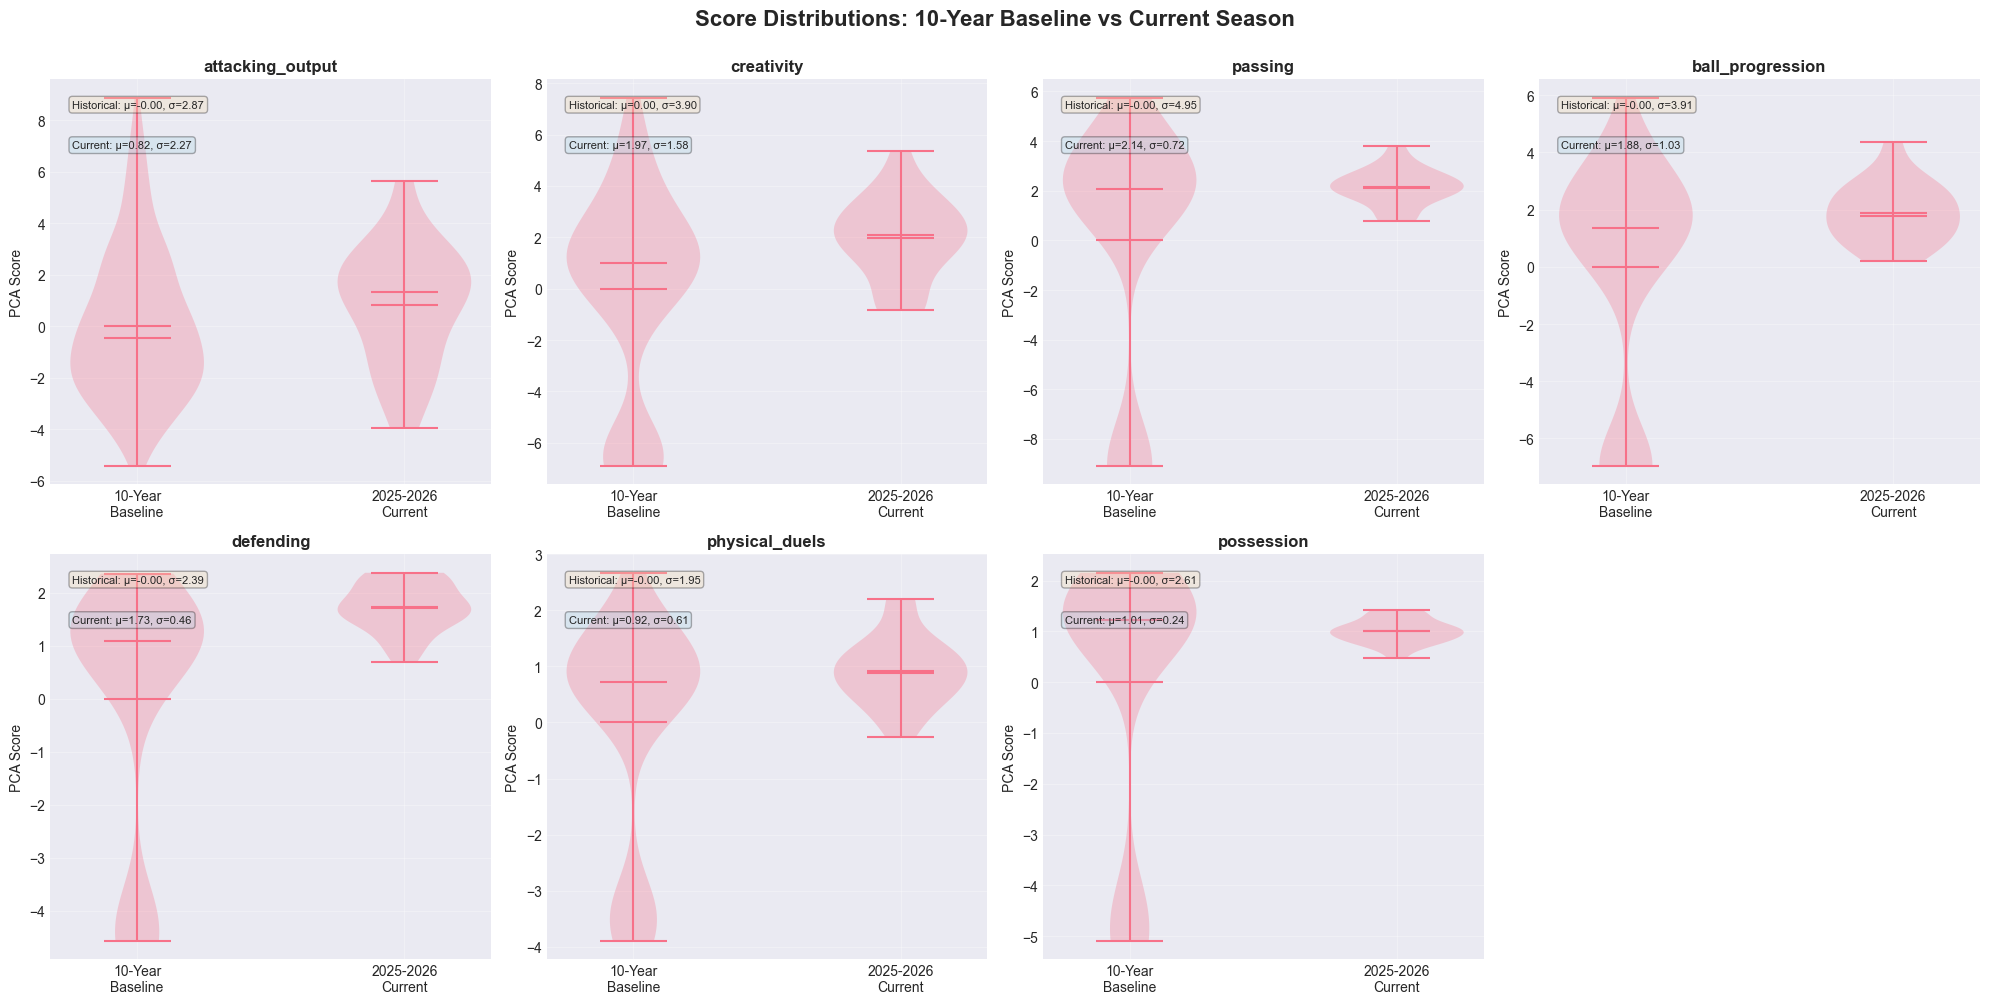


💡 Interpretation:
   - Wider violins = more variance in performance
   - Shifted distributions = current season differs from historical average
   - These are absolute scores (not normalized 0-100)


In [95]:
# Create violin plots comparing current to historical
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, cat_name in enumerate(FULL_CATEGORIES.keys()):
    ax = axes[idx]

    # Get historical scores
    cat_df = category_data[cat_name]
    metrics = category_metrics[cat_name]
    X = cat_df[metrics].values

    scaler = baseline_results[cat_name]['scaler']
    pca = baseline_results[cat_name]['pca']
    n_components = baseline_results[cat_name]['n_components']
    explained_var = baseline_results[cat_name]['explained_variance_ratio']

    X_scaled = scaler.transform(X)
    X_pca = pca.transform(X_scaled)
    hist_scores, _ = calculate_weighted_scores(X_pca, explained_var, n_components)

    # Get current scores
    curr_scores = current_scores[cat_name]['pca_score'].values

    # Create violin plot
    data_to_plot = [hist_scores, curr_scores]
    parts = ax.violinplot(data_to_plot, positions=[1, 2], showmeans=True, showmedians=True)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['10-Year\nBaseline', '2025-2026\nCurrent'])
    ax.set_ylabel('PCA Score')
    ax.set_title(cat_name, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add statistics
    ax.text(0.05, 0.95, f'Historical: μ={hist_scores.mean():.2f}, σ={hist_scores.std():.2f}',
            transform=ax.transAxes, va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax.text(0.05, 0.85, f'Current: μ={curr_scores.mean():.2f}, σ={curr_scores.std():.2f}',
            transform=ax.transAxes, va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Score Distributions: 10-Year Baseline vs Current Season', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - Wider violins = more variance in performance")
print("   - Shifted distributions = current season differs from historical average")
print("   - These are absolute scores (not normalized 0-100)")

## 10. Summary & Recommendations

In [96]:
print("="*80)
print("FINAL ASSESSMENT - 10-YEAR BASELINE PCA")
print("="*80)

print("\n📊 PC1 VARIANCE:")
for cat_name in FULL_CATEGORIES.keys():
    pc1_var = baseline_results[cat_name]['pc1_variance']
    status = '✅ Strong' if pc1_var > 0.5 else '⚠️  Moderate' if pc1_var > 0.35 else '❌ Weak'
    print(f"   {cat_name:20s}: {pc1_var:5.1%}  {status}")

print("\n📊 LOADING STABILITY:")
for cat_name in FULL_CATEGORIES.keys():
    stability = baseline_results[cat_name]['stability']
    print(f"   {cat_name:20s}: {stability['stability_score']:5.1%}  {stability['is_stable'] and '✅ STABLE' or '⚠️  UNSTABLE'}")

print("\n💡 RECOMMENDATIONS:")
print("\n1. Categories suitable for 10-year baseline:")
suitable = [cat for cat in FULL_CATEGORIES.keys()
           if baseline_results[cat]['stability']['is_stable']
           and baseline_results[cat]['pc1_variance'] > 0.4]
print(f"   {', '.join(suitable)}")
print("   → Use baseline model for absolute scoring across seasons")

print("\n2. Categories needing dynamic approach:")
dynamic = [cat for cat in FULL_CATEGORIES.keys() if cat not in suitable]
print(f"   {', '.join(dynamic)}")
print("   → Consider rolling window or season-specific PCA")

print("\n3. Next steps:")
print("   → Test correlation with league position (notebook 03)")
print("   → Compare PCA vs equal-weight composite scores")
print("   → Validate predictions on held-out seasons")

print("\n" + "="*80)
print("✅ COMPREHENSIVE 10-YEAR BASELINE ANALYSIS COMPLETE")
print("="*80)

FINAL ASSESSMENT - 10-YEAR BASELINE PCA

📊 PC1 VARIANCE:
   attacking_output    : 55.3%  ✅ Strong
   creativity          : 73.3%  ✅ Strong
   passing             : 87.5%  ✅ Strong
   ball_progression    : 84.9%  ✅ Strong
   defending           : 46.1%  ⚠️  Moderate
   physical_duels      : 55.6%  ✅ Strong
   possession          : 77.6%  ✅ Strong

📊 LOADING STABILITY:
   attacking_output    : 80.0%  ✅ STABLE
   creativity          : 60.0%  ✅ STABLE
   passing             : 40.0%  ⚠️  UNSTABLE
   ball_progression    : 80.0%  ✅ STABLE
   defending           : 40.0%  ⚠️  UNSTABLE
   physical_duels      :  0.0%  ⚠️  UNSTABLE
   possession          : 40.0%  ⚠️  UNSTABLE

💡 RECOMMENDATIONS:

1. Categories suitable for 10-year baseline:
   attacking_output, creativity, ball_progression
   → Use baseline model for absolute scoring across seasons

2. Categories needing dynamic approach:
   passing, defending, physical_duels, possession
   → Consider rolling window or season-specific PCA

3. Next